In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import time

import shutil
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F
import copy
import scipy.io
from sklearn.metrics import r2_score
import time
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
np.random.seed(54545467)
torch.manual_seed(54545467)


In [3]:
encoded_size=3
BC_cond=4
time_Step=10

## Hyperparameters for training GRU+FC

In [13]:
#Prevvious hidden=55 lr_decay=0.67

LSTM_parameters={'input_size':encoded_size+BC_cond,'hidden_size':77,
              'num_layers': 1,
              'output_size': encoded_size*time_Step}

trainer_info={'epochs': 250,
                'train_size': 6501,
                'train_batch':16,
                'test_batch': 4096,
                'lr0': 0.6e-3,
                'lr_decay': 0.72}


'''LSTM_parameters={'input_size':9,'hidden_size':60,
              'num_layers': 2,
              'output_size': 3}

trainer_info={'epochs': 600,
                'train_size': 6501,
                'train_batch': 16,
                'test_batch': 4096,
                'lr0': 1e-3,
                'lr_decay': 0.60}'''

print_freq=400
device = torch.device('cuda')
note = 'LSTM_DNN'
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(LSTM_parameters['num_layers']) + 'layer_' + str(LSTM_parameters['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note


## Define Class

In [14]:
class LSTM(nn.Module):
    def __init__(self,LSTM_parameters):
        super().__init__()

        input_size = LSTM_parameters['input_size']
        self.hidden_size = LSTM_parameters['hidden_size']
        self.num_layers = LSTM_parameters['num_layers']
        output_size = LSTM_parameters['output_size']

        self.leakrelu = torch.nn.LeakyReLU(negative_slope=0.01)
        
        self.tanh=torch.nn.Tanh()

        self.lstm1 = torch.nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
    
        self.dropout=torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self,x):

        a0=torch.zeros(self.num_layers,x.shape[0],self.hidden_size).to(device)

        c0=torch.zeros(self.num_layers,x.shape[0],self.hidden_size).to(device)

        #out,(a,c)=self.lstm1(x,(a0,c0))
        out,a=self.lstm1(x,(a0))
        
        #out=self.dropout(out)
        
        #out=self.leakrelu(out)
        out = self.fc1(out)
        #out = self.leakrelu(out)

        return out
    
class DNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=torch.nn.Linear(in_features=encoded_size*time_Step,out_features=40,bias=True)
        self.fc2=torch.nn.Linear(in_features=40,out_features=80,bias=True)
        self.fc3=torch.nn.Linear(in_features=80, out_features=160,bias=True)
        self.fc4=torch.nn.Linear(in_features=160, out_features=encoded_size*time_Step,bias=True)
        '''self.fc5=torch.nn.Linear(in_features=320, out_features=640,bias=True)
        self.fc6=torch.nn.Linear(in_features=640, out_features=4,bias=True)'''
        self.actfunc=torch.nn.LeakyReLU(negative_slope=0.01)

    def forward(self,x):
     
        z1=self.fc1(x)
        a1=self.actfunc(z1)
 
        z2=self.fc2(a1)
        a2=self.actfunc(z2)
     

        z3=self.fc3(a2)
        a3=self.actfunc(z3)


        z4=self.fc4(a3)
        a4=self.actfunc(z4)
        '''z5=self.fc5(a4)
        a5=self.actfunc(z5)


        z6=self.fc6(a5)
        a6=self.actfunc(z6)'''
        
        return a4

class LSTMDNN(nn.Module):
    def __init__(self,LSTM_parameters):
        super().__init__()
        self.lstm=LSTM(LSTM_parameters)
        #self.dnn=DNN()

    def init_weights(self):
        with torch.set_grad_enabled(True):
            
            for name, param in self.named_parameters():
                print(f"Initializing parameter '{name}' with shape: {param.shape}")
                if 'weight' in name:
                    # Use one of the initialization methods
                    #nn.init.xavier_uniform_(param)
                    # nn.init.xavier_normal_(param)
                    # nn.init.kaiming_uniform_(param, nonlinearity='relu')
                     #nn.init.kaiming_normal_(param, nonlinearity='relu')
                    # nn.init.uniform_(param, a=-0.1, b=0.1)
                     #nn.init.normal_(param, mean=0.0, std=0.02)
                    nn.init.orthogonal_(param)
                    # nn.init.sparse_(param, sparsity=0.1)
                elif 'bias' in name:
                    nn.init.constant_(param, 0.0)

    def forward(self,x):
        out=self.lstm(x)

        #pred=self.dnn(out[:,out.shape[1]-1,:])
        return out[:,out.shape[1]-1,:]

## Uilities

In [15]:
class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.     # value
        self.avg = 0.     # averaged value
        self.sum = 0.
        self.count = 0.   # total number of values

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        super().__init__()
        self.inp = inp
        self.out = out

    # This method overloads the built-in function len()
    def __len__(self):
        return self.inp.shape[0]

    # This method overloads the subscription operator '[]', when the object
    # is subscripted like X_train[], the system returns a tuple of objects.
    def __getitem__(self, index):
        return self.inp[index,:], self.out[index,:]

## Training Function

In [16]:
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output= model(input)
    
        loss = criterion(output, target)
        
        #print(enc)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()
        
        '''for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Gradient for parameter '{name}':\n{param.grad}")
            else:
                print(f"No gradient for parameter '{name}'")'''

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg


def test_step(test_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(test_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))

    return losses.avg

#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_LSTM_Tempo_Temperature_interpol_80_(1500-3000)_uniform(single).pth.tar')



In [17]:
def train_LSTM_DNN(model, net_info, train_loader, test_loader,LSTM_parameters):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'],weight_decay=1e-8)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 28:
            if epoch % 28 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training and Test Loss\n(hidden size=%s, num layers=%s model'%(LSTM_parameters['hidden_size'],LSTM_parameters['num_layers']))
    plt.yscale('log')
    plt.legend()
    plt.show()
    return model

In [9]:
def main_program(T_S, T_S_out,val_T_S, val_T_S_out,LSTM_parameters, model,trainer_info, model_name):
    num_sample = trainer_info['train_size']
    T_S_train = T_S[:, :, :]
    T_S_out_train = T_S_out[:, :]
    training_set = MyDataset(T_S_train, T_S_out_train)

    T_S_test = val_T_S[:, :, :]
    T_S_out_test = val_T_S_out[:, :]
    val_set = MyDataset(T_S_test, T_S_out_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = train_LSTM_DNN(model, trainer_info, train_loader, test_loader,LSTM_parameters)
    torch.save(model.state_dict(), model_name)

    return model

## Loading data for training

In [10]:
In=loadmat("TrainingIn")
TrainIn=In['red_train'].astype(np.float32)
Out=loadmat("TrainingOut")
TrainOut=Out['red_train'].astype(np.float32)


In=loadmat("Validation_In")
ValIn=In['val_train'].astype(np.float32)
Out=loadmat("Validation_Out")
ValOut=Out['val_train'].astype(np.float32)

In=loadmat("Test_In")
TestIn=In['red_test'].astype(np.float32)
Out=loadmat("Test_Out")
TestOut=Out['red_test'].astype(np.float32)

time=loadmat("Input_BC")
time=time['BC'].astype(np.float32)[:,0]

hours=time/(3600)



Epoch: [0/250][0/168]	LR: 0.0006	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0254342 (0.025434)	
Test: [0/1]	Time 0.002 (0.002)	Loss 0.0006506 (0.0007)	
Epoch: [25/250][0/168]	LR: 0.0006	Time 0.003 (0.003)	Data 0.001 (0.001)	Loss 0.0000004 (0.000000)	
Test: [0/1]	Time 0.074 (0.074)	Loss 0.0000011 (0.0000)	
Epoch: [50/250][0/168]	LR: 0.00043199999999999993	Time 0.006 (0.006)	Data 0.001 (0.001)	Loss 0.0000006 (0.000001)	
Test: [0/1]	Time 0.095 (0.095)	Loss 0.0000072 (0.0000)	
Epoch: [75/250][0/168]	LR: 0.00031103999999999995	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.0000002 (0.000000)	
Test: [0/1]	Time 0.008 (0.008)	Loss 0.0000064 (0.0000)	
Epoch: [100/250][0/168]	LR: 0.00022394879999999997	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0000001 (0.000000)	
Test: [0/1]	Time 0.058 (0.058)	Loss 0.0000006 (0.0000)	
Epoch: [125/250][0/168]	LR: 0.00016124313599999996	Time 0.004 (0.004)	Data 0.001 (0.001)	Loss 0.0000007 (0.000001)	
Test: [0/1]	Time 0.047 (0.047)	Loss 0.0000007 (0.0000)	
Epoch

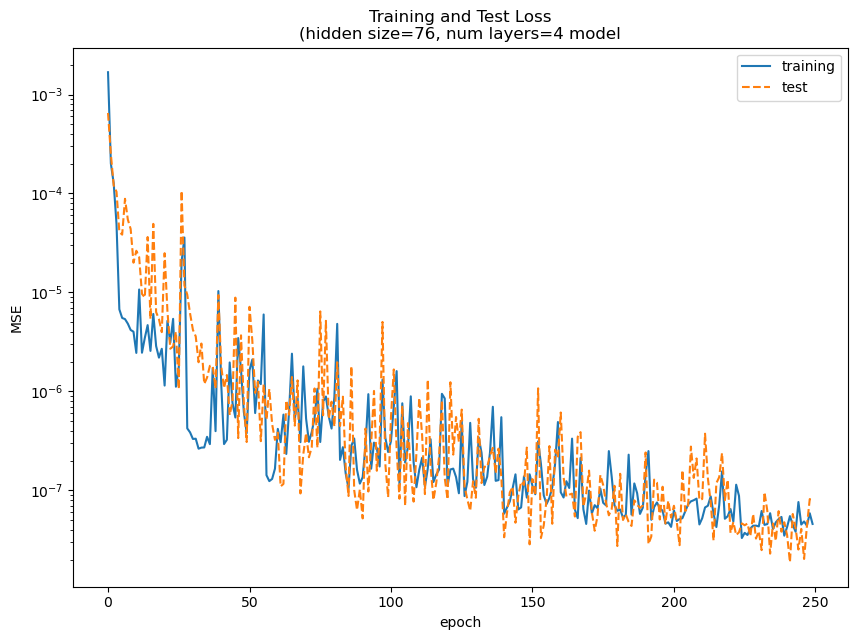

Total execution time: 118.15047335624695 seconds


In [163]:
import time
start_time = time.time()

model=LSTMDNN(LSTM_parameters).to(device)
model = main_program(TrainIn, TrainOut,ValIn,ValOut,LSTM_parameters,model, trainer_info, model_name)
end_time = time.time()
# Calculate and print the total execution time
total_execution_time = end_time - start_time
print(f"Total execution time: {total_execution_time} seconds")



## Load the weights and model

In [18]:
best_model_params = torch.load('model_LSTM_Tempo_Temperature_interpol_80_(1500-3000)_(8000-8500).pth.tar', map_location=device)['state_dict']


In [19]:
model=LSTMDNN(LSTM_parameters).to(device)
model.load_state_dict(best_model_params)

<All keys matched successfully>

In [20]:
time_step=10

In [21]:
Val=loadmat('Val_Inital.mat')
Val_init=Val['Val']
BC_val=loadmat('BC_val.mat')
BCval=BC_val['BC_val']
print(BC_val['BC_val'].shape)


dt_val=loadmat('dt_val.mat')
dt_val=dt_val['dt_val']
Val_init=torch.from_numpy(Val_init).float().to(device)

BCval=torch.from_numpy(BCval).float().to(device)

dt_val=torch.from_numpy(dt_val).float().to(device)

print(BCval.shape)

(300, 4)
torch.Size([300, 4])


In [22]:
Test=loadmat('Test_Inital.mat')
Test_init=Test['Test']
BC_test=loadmat('BC_test.mat')
BC=BC_test['BC_test'][time_step:]

dt_test=loadmat('dt_test.mat')
dt_test=dt_test['dt_test'][time_step:]



#print(BC_test['BC_test'].shape)
Test_init=torch.from_numpy(Test_init).float().to(device)

BC=torch.from_numpy(BC).float().to(device)
dt_test=torch.from_numpy(dt_test).float().to(device)

print(Test_init.shape)
print(BC.shape)


torch.Size([1, 10, 7])
torch.Size([6000, 4])


## Autoregressively predicting the validation set

In [23]:
## For multiple output validation(1500-2500)
predictions_val=torch.zeros([int(300/time_Step),encoded_size*time_step])
p=0
for i in range(int(300/time_Step)):
    #print(Test_init)
    predictions_val[i,:]=model(Val_init)
    Val_init[:,:,0:encoded_size]=predictions_val[i,:].reshape(1,time_step,encoded_size)
    Val_init[0,:,encoded_size:]=BCval[p:p+time_step,:]
    #Val_init[0,:,-1]=dt_val[p:p+time_step,0]
    p=p+time_step
    
predictionval=torch.zeros([300,encoded_size])
k=0
for i in range(int(300/time_Step)):
    l=0
    for j in range(time_Step):
        predictionval[k,:]=predictions_val[i,l:l+3]
        k=k+1
        l=l+3

## Autoregressively predicting the test set

In [24]:
## For multiple output (1500-3000)
total=6000
predictions=torch.zeros([int(total/time_Step),encoded_size*time_step])
p=0
for i in range(int(total/time_Step)):
    #print(Test_init)
    predictions[i,:]=model(Test_init)
    Test_init[:,:,0:encoded_size]=predictions[i,:].reshape(1,time_step,encoded_size)
    Test_init[0,:,encoded_size:]=BC[p:p+time_step,:]
    #Test_init[0,:,-1]=dt_test[p:p+time_step,0]
    p=p+time_step
    
prediction=torch.zeros([total,encoded_size])
k=0
for i in range(int(total/time_Step)):
    l=0
    for j in range(time_Step):
        prediction[k,:]=predictions[i,l:l+encoded_size]
        k=k+1
        l=l+encoded_size

In [25]:
filename='predictions_encodings.mat'
predictions_enc={'pred':prediction.cpu().detach().numpy()}

scipy.io.savemat(filename,predictions_enc)

print(prediction.shape)

uni_days=np.linspace(0,6.831762,4500)


torch.Size([6000, 3])


In [26]:
Val=loadmat('Val_Set.mat')
Val_encodings_actual=Val['Val_Set']

## Results on Validation set

Text(0.5, 0.98, 'Comparison of evolution of two Latent space variables between True and Predicted')

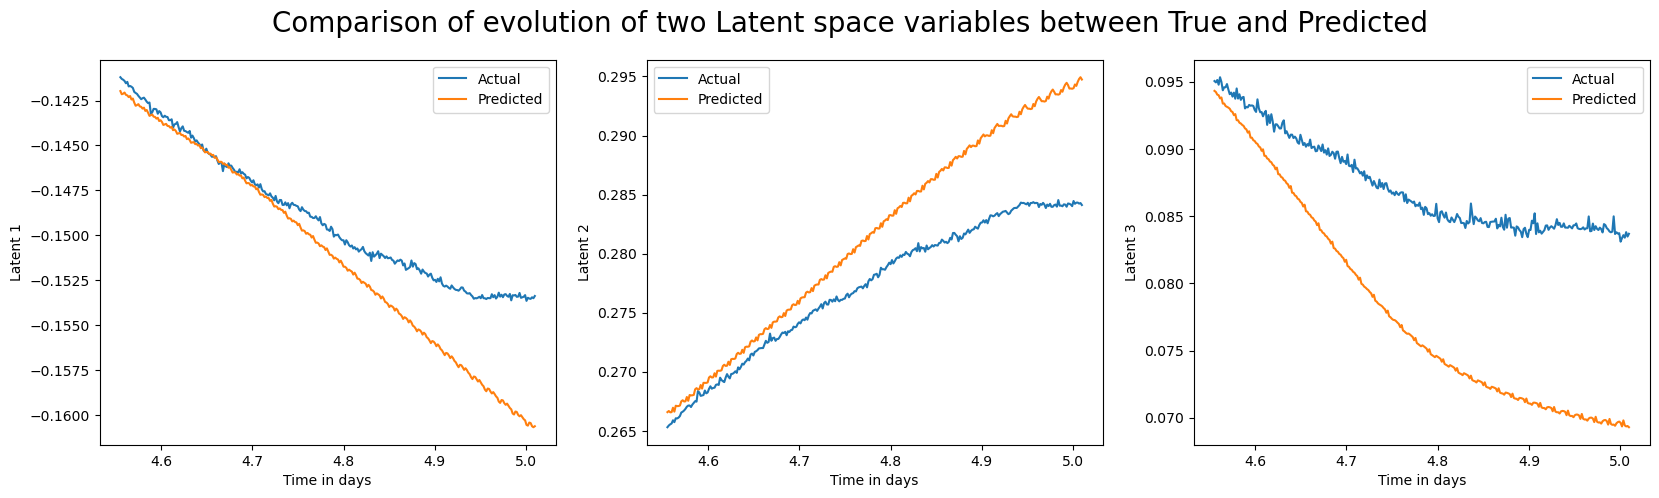

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
Start=0
End=300
stride=1
days=hours/24

ax[0].plot(uni_days[Start+3000:End+3000],Val_encodings_actual[Start:End:stride, 0],label='Actual')
ax[0].plot(uni_days[Start+3000:End+3000],predictionval.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted')
ax[0].set_xlabel('Time in days')
ax[0].set_ylabel('Latent 1')

ax[1].plot(uni_days[Start+3000:End+3000],Val_encodings_actual[Start:End:stride, 1],label='Actual')
ax[1].plot(uni_days[Start+3000:End+3000],predictionval.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted')
ax[1].set_xlabel('Time in days')
ax[1].set_ylabel('Latent 2')

ax[2].plot(uni_days[Start+3000:End+3000],Val_encodings_actual[Start:End:stride, 2],label='Actual')
ax[2].plot(uni_days[Start+3000:End+3000],predictionval.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted')
ax[2].set_xlabel('Time in days')
ax[2].set_ylabel('Latent 3')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.suptitle('Comparison of evolution of two Latent space variables between True and Predicted',fontsize=20)



## Results on Test set

In [28]:


Test=loadmat('Test_Set.mat')

Test_encodings_actual=Test['Test_Set']

In [29]:
print(prediction)
print(prediction.shape)

filename6='Test_actual_predicted_encodings.mat'
test={'Actual':Test_encodings_actual,'Predicted':prediction.cpu().detach().numpy()}

scipy.io.savemat(filename6,test)


tensor([[ 0.0704, -0.0555,  0.0077],
        [ 0.0705, -0.0554,  0.0075],
        [ 0.0703, -0.0550,  0.0076],
        ...,
        [-0.2075,  0.2902, -0.1101],
        [-0.2076,  0.2904, -0.1101],
        [-0.2074,  0.2902, -0.1101]], grad_fn=<CopySlices>)
torch.Size([6000, 3])


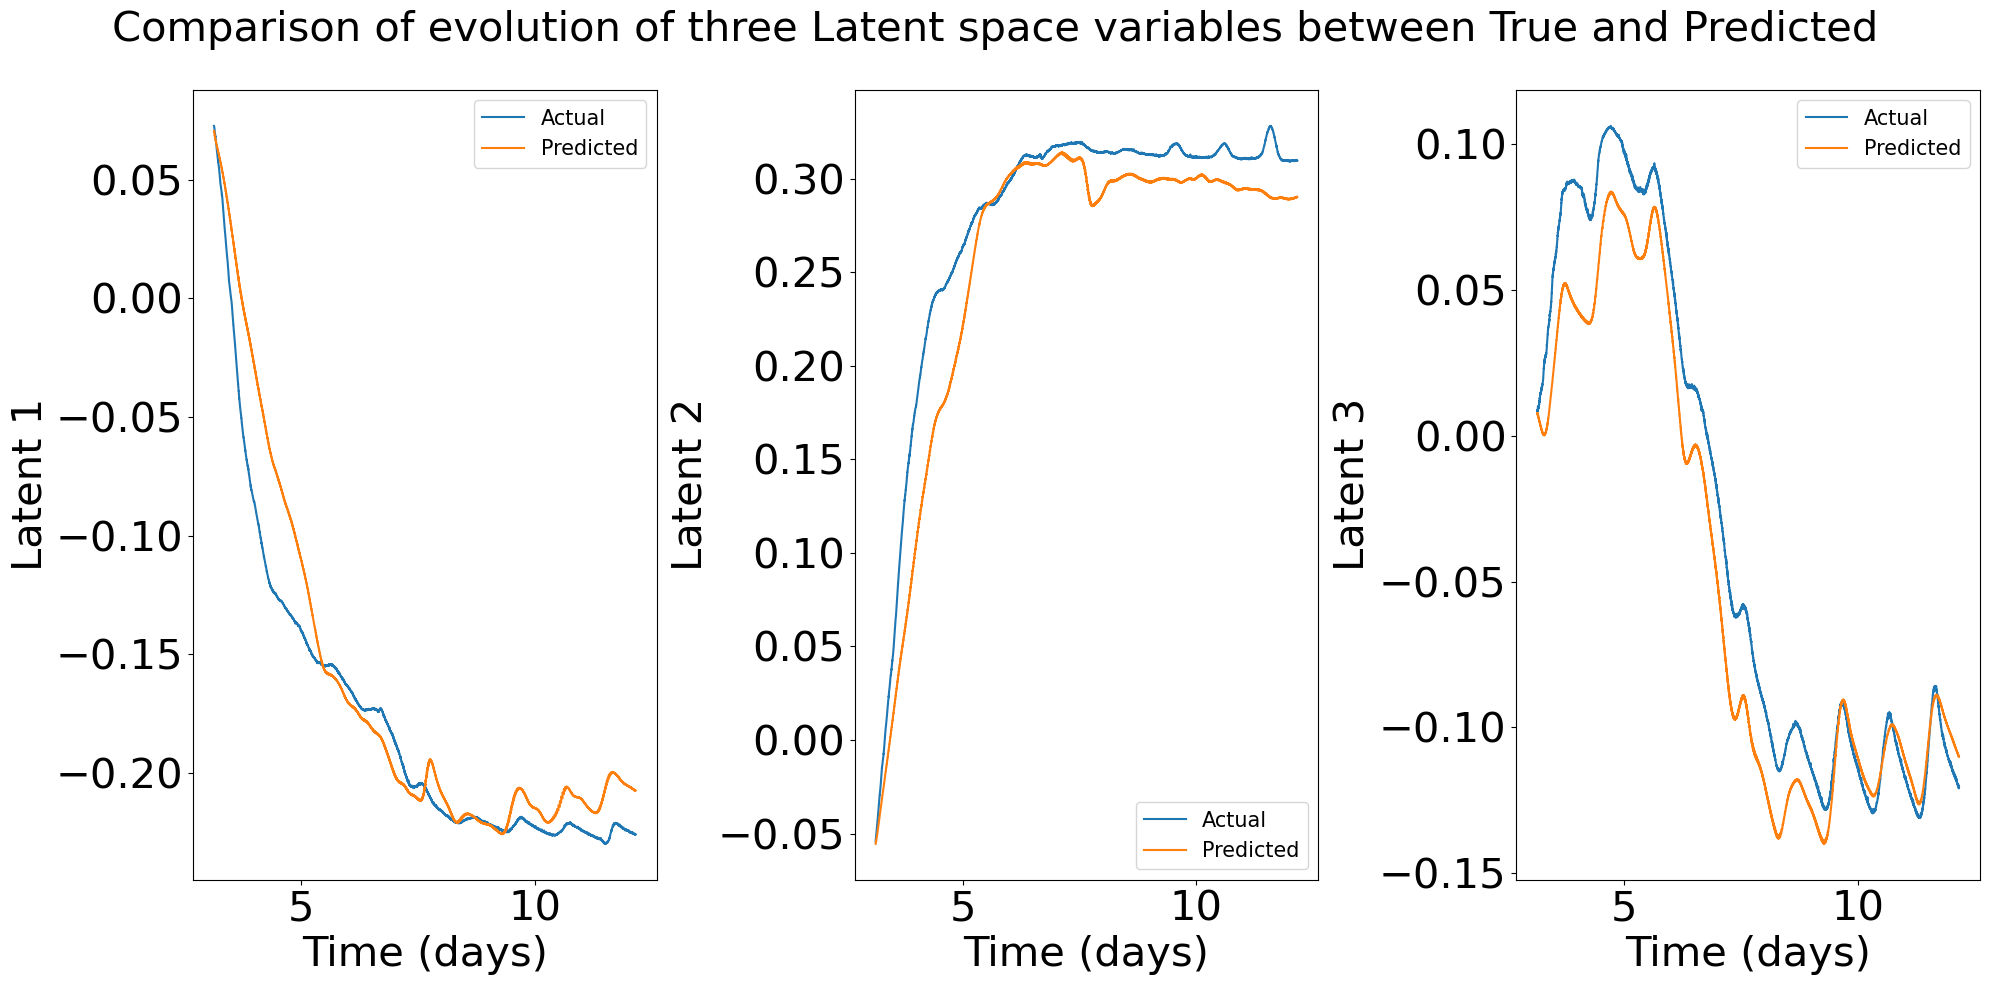

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
Start=0
End=1500
stride=1
days=hours/24

ax[0].plot(days[Start+1500:End+1500],Test_encodings_actual[Start:End:stride, 0],label='Actual')
ax[0].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted')
ax[0].set_xlabel('Time (days)',fontsize=30)
ax[0].set_ylabel('Latent 1',fontsize=30)

ax[1].plot(days[Start+1500:End+1500],Test_encodings_actual[Start:End:stride, 1],label='Actual')
ax[1].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted')
ax[1].set_xlabel('Time (days)',fontsize=30)
ax[1].set_ylabel('Latent 2',fontsize=30)

ax[2].plot(days[Start+1500:End+1500],Test_encodings_actual[Start:End:stride, 2],label='Actual')
ax[2].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted')
ax[2].set_xlabel('Time (days)',fontsize=30)
ax[2].set_ylabel('Latent 3',fontsize=30)

ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)

ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)
ax[2].tick_params(axis='both', labelsize=30)

plt.tight_layout()
plt.suptitle('Comparison of evolution of three Latent space variables between True and Predicted',fontsize=30)
plt.subplots_adjust(top=0.9)



In [58]:
red_al=loadmat('reduced_all.mat')
red_al=red_al['red_all']

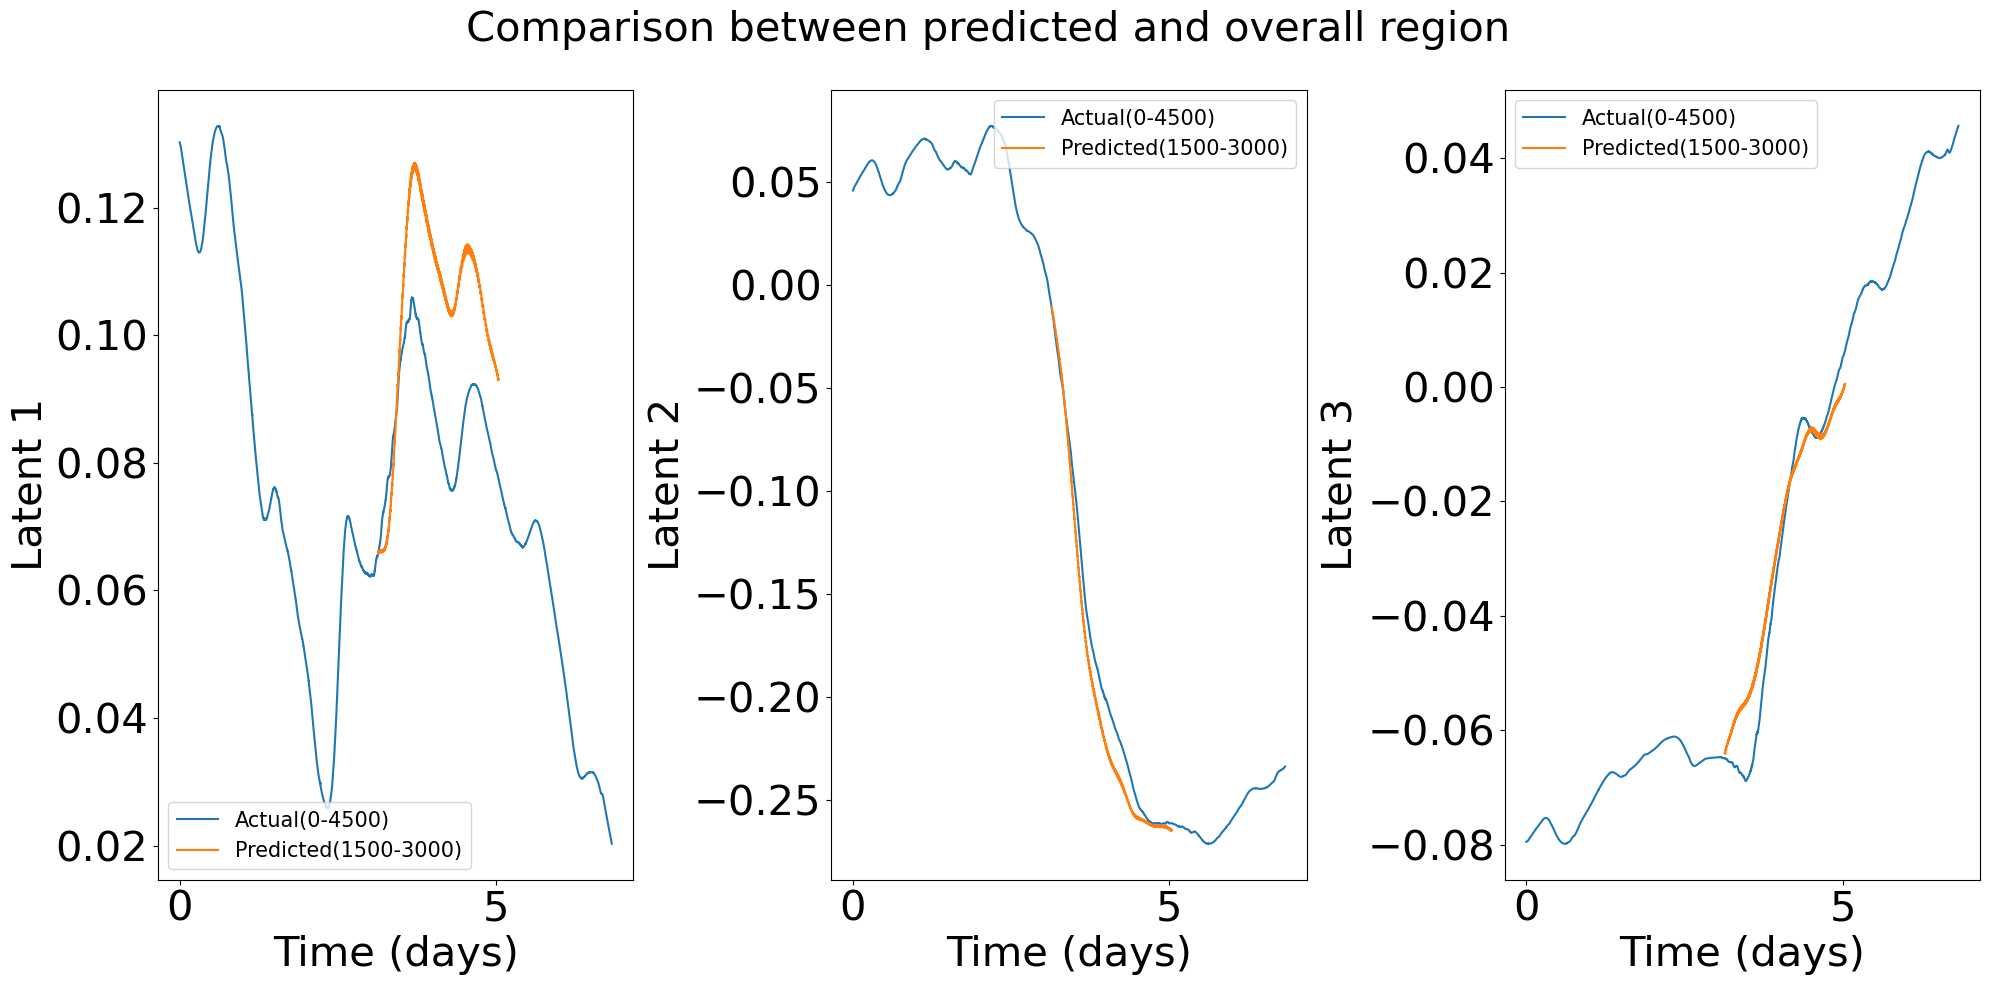

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
Start=0
End=1500
stride=1
days=hours/24

ax[0].plot(days[:4500],red_al[:, 0],label='Actual(0-4500)')
ax[0].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted(1500-3000)')
ax[0].set_xlabel('Time (days)',fontsize=30)
ax[0].set_ylabel('Latent 1',fontsize=30)

ax[1].plot(days[:4500],red_al[:, 1],label='Actual(0-4500)')
ax[1].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted(1500-3000)')
ax[1].set_xlabel('Time (days)',fontsize=30)
ax[1].set_ylabel('Latent 2',fontsize=30)

ax[2].plot(days[:4500],red_al[:, 2],label='Actual(0-4500)')
ax[2].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted(1500-3000)')
ax[2].set_xlabel('Time (days)',fontsize=30)
ax[2].set_ylabel('Latent 3',fontsize=30)

ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)

ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)
ax[2].tick_params(axis='both', labelsize=30)

plt.tight_layout()
plt.suptitle('Comparison between predicted and overall region ',fontsize=30)
plt.subplots_adjust(top=0.9)